# Flight Price Predictor
We will use the data that was scraped and somewhat cleaned/processed before, please refer to Github Repos.
Web Scraper:
Data Cleaning:

### Schema
- First we will load and do some exploratory data analysis with the data we have.
- Then we will train a RandomForestRegressor model.
- After that we will turn it into a web app.



## Part 1, EDA
Let's start with importing the necessary libraries for EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,price,carrier,start_date,end_date,total_stops,dep_time_outbound,dep_time_inbound,duration_outbound,duration_inbound,from,...,day_of_week,outbound_duration_minutes,inbound_duration_minutes,time_of_day_outbound,time_of_day_inbound,day_of_year,month_number,day_of_month,month_number_end,day_of_month_end
0,1557,Delta,02/01/2024,02/08/2024,0,10:00 AM,2:05 PM,11h 0m,10h 10m,AMS,...,3,660.0,610.0,Morning,Early Morning,32,2,1,2,8
1,1557,Delta,02/01/2024,02/08/2024,1,10:00 AM,10:45 AM,11h 0m,13h 20m,AMS,...,3,660.0,800.0,Morning,Morning,32,2,1,2,8
2,1582,Multiple Airlines,02/01/2024,02/08/2024,0,10:00 AM,2:05 PM,11h 0m,10h 10m,AMS,...,3,660.0,610.0,Morning,Early Morning,32,2,1,2,8
3,1582,Multiple Airlines,02/01/2024,02/08/2024,1,10:00 AM,10:45 AM,11h 0m,13h 20m,AMS,...,3,660.0,800.0,Morning,Morning,32,2,1,2,8
4,1591,Multiple Airlines,02/01/2024,02/08/2024,0,10:00 AM,2:05 PM,11h 0m,10h 10m,AMS,...,3,660.0,610.0,Morning,Early Morning,32,2,1,2,8


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771344 entries, 0 to 771343
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   price                      771344 non-null  int64  
 1   carrier                    771344 non-null  object 
 2   start_date                 771344 non-null  object 
 3   end_date                   771344 non-null  object 
 4   total_stops                771344 non-null  int64  
 5   dep_time_outbound          771344 non-null  object 
 6   dep_time_inbound           771344 non-null  object 
 7   duration_outbound          771344 non-null  object 
 8   duration_inbound           771344 non-null  object 
 9   from                       771344 non-null  object 
 10  to                         771344 non-null  object 
 11  day_of_week                771344 non-null  int64  
 12  outbound_duration_minutes  771344 non-null  float64
 13  inbound_duration_minutes   77

Because this data is already processed, there are no missing data. Which is a good thing. But when we cleaned the data, we did not look for duplicate values. Which might exist. We also need to deal with categorical columns. We will use label encoder for that. And some of the data will not be useful, we will drop them aswell when needed.

In [5]:
data.duplicated().sum()

24019

There are 24k rows of duplicated data, we will drop them.

In [6]:
data = data.drop_duplicates()

Starting with dates, we can turn them to datetime objects and normalize the starting days, because I know for a fact that these dates are randomly selected and does not match fully.

In [7]:
data["start_date"] = pd.to_datetime(data["start_date"])
data["end_date"] = pd.to_datetime(data["end_date"])

In [8]:
data["from"].unique()

array(['AMS', 'LHR'], dtype=object)

In [9]:
data["to"].unique()

array(['SFO', 'CPT', 'DXB', 'NYC', 'BKK', 'KUL', 'SIN', 'IKA'],
      dtype=object)

In [10]:
for origin in list(data["from"].unique()):
    for destination in list(data["to"].unique()):
        print(origin, " ", destination ," ", "Start Date First: ",data[(data["from"] == origin) & (data["to"] == destination)]["start_date"].min())
        print(origin, " ", destination ," ", "Start Date Last: ",data[(data["from"] == origin) & (data["to"] == destination)]["start_date"].max())
        print("\n")

AMS   SFO   Start Date First:  2024-02-01 00:00:00
AMS   SFO   Start Date Last:  2024-12-27 00:00:00


AMS   CPT   Start Date First:  2024-02-10 00:00:00
AMS   CPT   Start Date Last:  2025-01-05 00:00:00


AMS   DXB   Start Date First:  2024-02-10 00:00:00
AMS   DXB   Start Date Last:  2025-01-05 00:00:00


AMS   NYC   Start Date First:  2024-02-01 00:00:00
AMS   NYC   Start Date Last:  2024-12-29 00:00:00


AMS   BKK   Start Date First:  2024-02-01 00:00:00
AMS   BKK   Start Date Last:  2025-01-25 00:00:00


AMS   KUL   Start Date First:  2024-02-10 00:00:00
AMS   KUL   Start Date Last:  2024-12-13 00:00:00


AMS   SIN   Start Date First:  2024-03-15 00:00:00
AMS   SIN   Start Date Last:  2024-12-04 00:00:00


AMS   IKA   Start Date First:  2024-02-01 00:00:00
AMS   IKA   Start Date Last:  2025-01-25 00:00:00


LHR   SFO   Start Date First:  2024-03-01 00:00:00
LHR   SFO   Start Date Last:  2025-01-25 00:00:00


LHR   CPT   Start Date First:  2024-03-01 00:00:00
LHR   CPT   Start Date

Okay looks like the earliest common start_date is 2024-03-15 and the latest start_date we can get is 2024-12-27. 
So the dates we will use are 2024-03-15 and 2024-12-25.

In [11]:
mask  = (data["start_date"] >= "2024-03-15") & (data["start_date"] <= "2024-12-25")
data = data[mask]
data.head()

,price,carrier,start_date,end_date,total_stops,dep_time_outbound,dep_time_inbound,duration_outbound,duration_inbound,from,...,day_of_week,outbound_duration_minutes,inbound_duration_minutes,time_of_day_outbound,time_of_day_inbound,day_of_year,month_number,day_of_month,month_number_end,day_of_month_end
3729,697,JetBlue,2024-03-15,2024-03-22,2,11:20 AM,2:01 PM,21h 20m,13h 34m,AMS,...,4,1280.0,814.0,Morning,Early Morning,75,3,15,3,22
3730,797,JetBlue,2024-03-15,2024-03-22,2,11:20 AM,11:12 AM,21h 20m,16h 23m,AMS,...,4,1280.0,983.0,Morning,Morning,75,3,15,3,22
3731,817,JetBlue,2024-03-15,2024-03-22,2,1:40 PM,2:01 PM,19h 36m,13h 34m,AMS,...,4,1176.0,814.0,Early Morning,Early Morning,75,3,15,3,22
3732,817,JetBlue,2024-03-15,2024-03-22,2,1:40 PM,2:01 PM,29h 20m,13h 34m,AMS,...,4,1760.0,814.0,Early Morning,Early Morning,75,3,15,3,22
3733,917,JetBlue,2024-03-15,2024-03-22,2,1:40 PM,11:12 AM,19h 36m,16h 23m,AMS,...,4,1176.0,983.0,Early Morning,Morning,75,3,15,3,22


Now that we are done with selecting a timeframe to work with, we can start exploratoriy data analysis.

<Axes: xlabel='month_number', ylabel='price'>

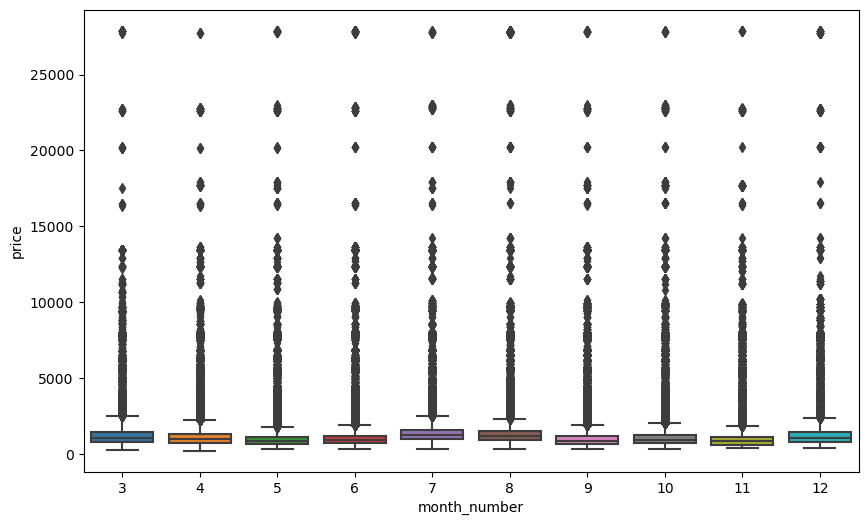

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(x="month_number",y="price",data=data)

Wow, thats so much outliers. We can try and deal with them by using Quantiles. We could have used the mean price for the entirety of the data, but it is known that flight prices tend to vary vastly for a given season so it only makes sense to drop outliers according to their months.

In [13]:
outliers_list =[]
for origin in ["AMS","LHR"]:
    for month in range(3,13):
        outlier_mask = (data["month_number"] == month) & (data["from"] == origin)
        q1 = data[outlier_mask]["price"].quantile(0.25)
        q3 = data[outlier_mask]["price"].quantile(0.75)
        IQR = q3-q1
        outliers = data[outlier_mask][(data[outlier_mask]["price"]<q1-1.2*IQR) | (data[outlier_mask]["price"]> q3+1.2*IQR)]
        outliers_list.append(outliers)
total_outliers = pd.concat(outliers_list)
len(total_outliers)

57036

In [14]:
data_quantiled = data.drop(total_outliers.index)

Now that we have cleaned the data let's see how's the outliers look like.

<Axes: xlabel='month_number', ylabel='price'>

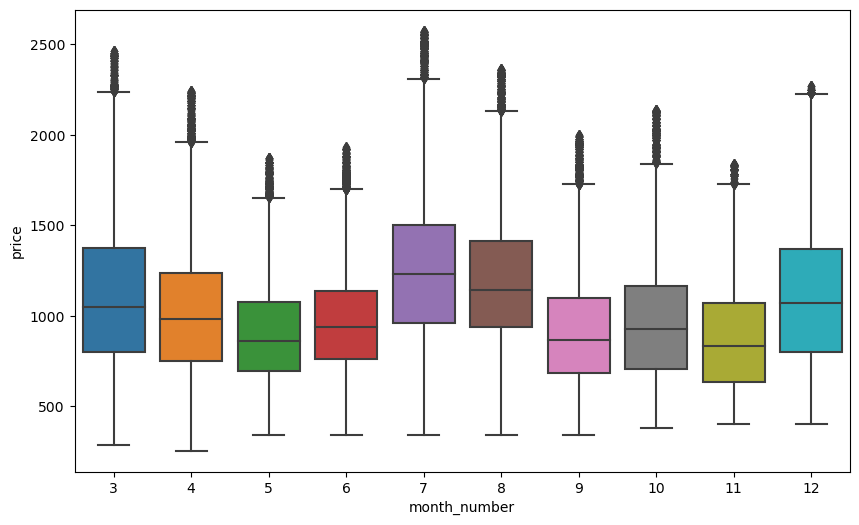

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x="month_number",y="price",data=data_quantiled)

Looks alot better now. But there seems to be a little more room for improvement, we can try and use z-score method on the already cleaned data and it could help us to get rid of most of the outliers.

In [16]:
from scipy import stats

In [17]:
data_quantiled["z_scores"] = np.abs(stats.zscore(data["price"]))
data_quantiled[data_quantiled["z_scores"] > 3]

,price,carrier,start_date,end_date,total_stops,dep_time_outbound,dep_time_inbound,duration_outbound,duration_inbound,from,...,outbound_duration_minutes,inbound_duration_minutes,time_of_day_outbound,time_of_day_inbound,day_of_year,month_number,day_of_month,month_number_end,day_of_month_end,z_scores


Looks like there are not any values that is more than 3 std away from the mean. We can stop eliminating outliers here. But there is no reason to keep analysing the data.


So far we know;
- Flight prices are highest in summer and christmas season.
- Lowest at november.

<Axes: xlabel='day_of_week', ylabel='price'>

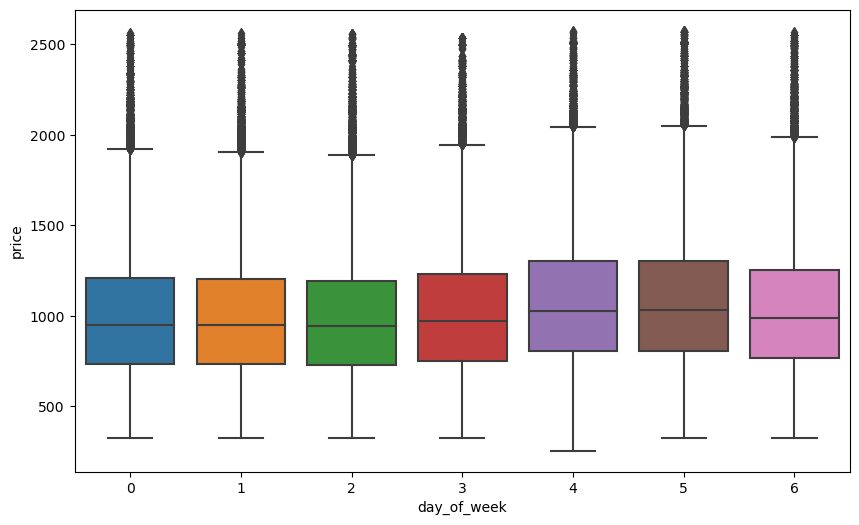

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x="day_of_week",y="price",data=data_quantiled)

We can also see that while prices tend to be the same throughout the weekdays, friday and saturday seems a little bit higher.

We can now start eliminating categorical columns. And see if we can extract anymore additional information.

In [19]:
from sklearn.preprocessing import LabelEncoder
le_car = LabelEncoder()
le_to = LabelEncoder()
le_from = LabelEncoder()
le_tod_ob = LabelEncoder()
le_tod_ib = LabelEncoder()

In [20]:
carriers_encoded = le_car.fit_transform(data_quantiled["carrier"])
to_encoded = le_to.fit_transform(data_quantiled["to"])
from_encoded = le_from.fit_transform(data_quantiled["from"])
tod_ob_encoded = le_tod_ob.fit_transform(data_quantiled["time_of_day_outbound"])
tod_ib_encoded = le_tod_ib.fit_transform(data_quantiled["time_of_day_inbound"])

In [21]:
data_transformed = data_quantiled.drop(['carrier', 'start_date', 'end_date','dep_time_outbound', 
                                'dep_time_inbound','duration_outbound',
                                'duration_inbound','from', 'to','time_of_day_outbound', 
                                'time_of_day_inbound','z_scores','month_number_end','day_of_month_end'],axis=1)

In [22]:
data_transformed.head()

,price,total_stops,day_of_week,outbound_duration_minutes,inbound_duration_minutes,day_of_year,month_number,day_of_month
3729,697,2,4,1280.0,814.0,75,3,15
3730,797,2,4,1280.0,983.0,75,3,15
3731,817,2,4,1176.0,814.0,75,3,15
3732,817,2,4,1760.0,814.0,75,3,15
3733,917,2,4,1176.0,983.0,75,3,15


In [23]:
data_transformed["to_encoded"] = to_encoded
data_transformed["from_encoded"] = from_encoded
data_transformed["carriers_encoded"] = carriers_encoded
data_transformed["tod_ib_encoded"] = tod_ib_encoded
data_transformed["tod_ob_encoded"] = tod_ob_encoded

In [24]:
data_transformed.head()

,price,total_stops,day_of_week,outbound_duration_minutes,inbound_duration_minutes,day_of_year,month_number,day_of_month,to_encoded,from_encoded,carriers_encoded,tod_ib_encoded,tod_ob_encoded
3729,697,2,4,1280.0,814.0,75,3,15,6,0,36,1,2
3730,797,2,4,1280.0,983.0,75,3,15,6,0,36,2,2
3731,817,2,4,1176.0,814.0,75,3,15,6,0,36,1,1
3732,817,2,4,1760.0,814.0,75,3,15,6,0,36,1,1
3733,917,2,4,1176.0,983.0,75,3,15,6,0,36,2,1


In [25]:
abs(data_transformed.corr()["price"]).sort_values(ascending=False)

price                        1.000000
inbound_duration_minutes     0.318555
outbound_duration_minutes    0.292005
total_stops                  0.202098
to_encoded                   0.124536
tod_ob_encoded               0.102602
from_encoded                 0.093957
carriers_encoded             0.076016
day_of_week                  0.073313
month_number                 0.047883
day_of_year                  0.045582
day_of_month                 0.031343
tod_ib_encoded               0.002017
Name: price, dtype: float64

Well, time of day inbound almost has no corelation with price. So lets get rid of that.

In [26]:
data_transformed.drop('tod_ib_encoded',axis=1,inplace=True)

<Axes: >

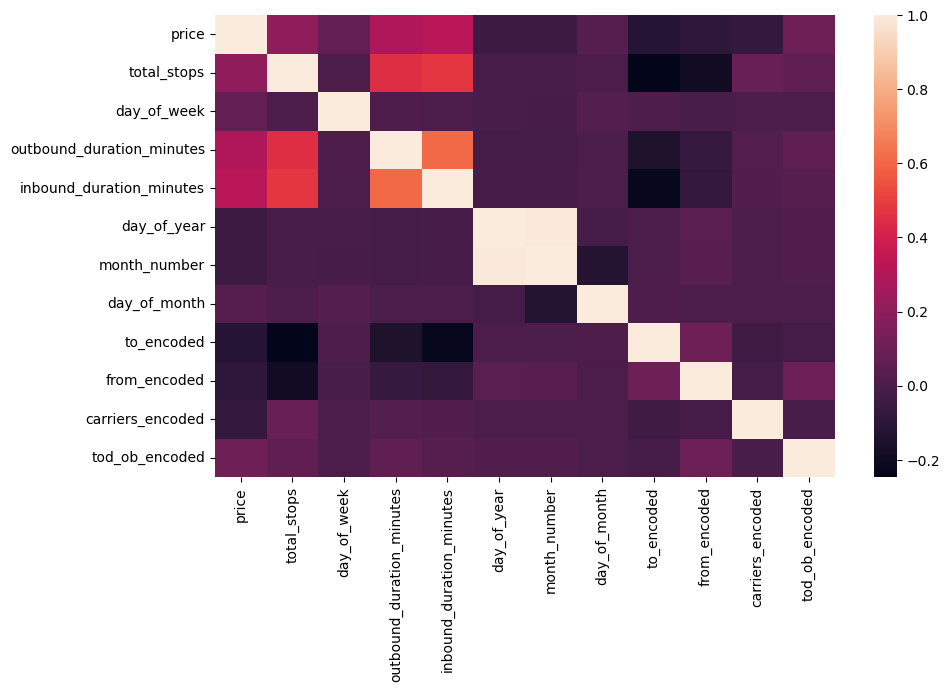

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(data_transformed.corr())

As expected, total stops and durations seems to corelate, also there is some corelation with origins,destinations and durations. Which makes sense.

## Part 2, Training the Model

Importing necessary libraries

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [29]:
X = data_transformed[['total_stops', 'day_of_week', 'month_number', 'day_of_month',
       'outbound_duration_minutes', 'inbound_duration_minutes', 'day_of_year',
       'to_encoded', 'from_encoded', 'carriers_encoded',
       'tod_ob_encoded']]
y= data_transformed["price"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [31]:
reg_rf = RandomForestRegressor(n_jobs=-1,n_estimators=30)

In [32]:
reg_rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=30, n_jobs=-1)

In [33]:
y_pred = reg_rf.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2: ', metrics.r2_score(y_test,y_pred))

MAE: 41.963954906267034
MSE: 7419.156704318343
RMSE: 86.13452678408551
R2:  0.9416848188601702


Mean absolute error is 42€, which is approximately %5 of the overall mean fare. Can be considered as an okay value, I was able to get it around 30€ but model gets too large to be deployed in anywhere.

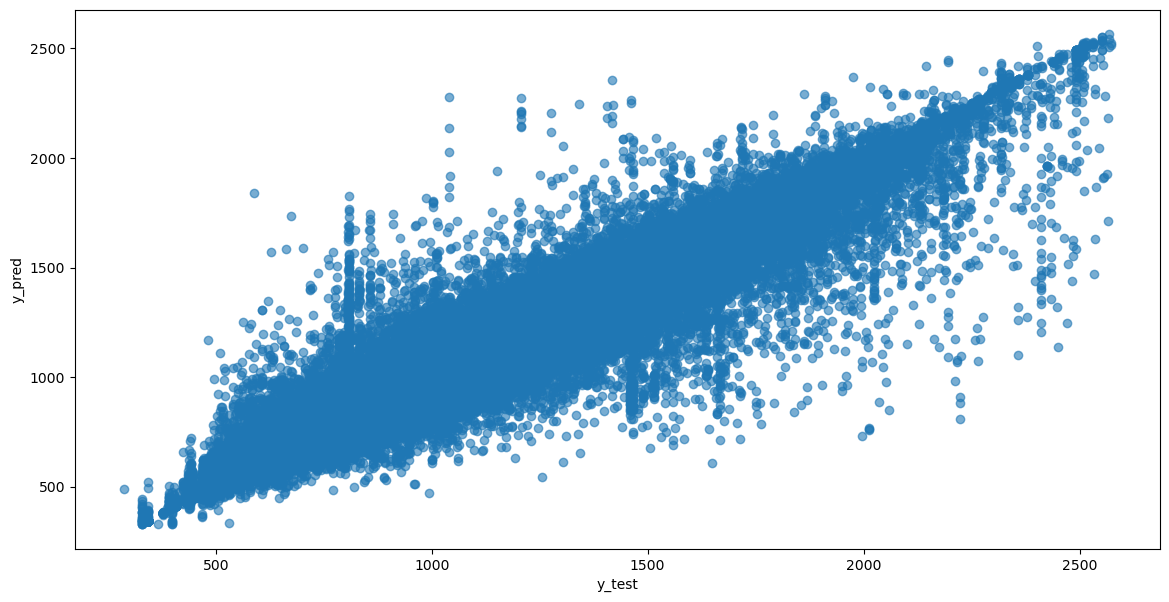

In [34]:
plt.figure(figsize=(14,7))
plt.scatter(x=y_test, y=y_pred, alpha =0.6)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

Here we can see some outliers, which is expected. But large sum of the data seems to be linearly distributed.

In [35]:
y_pred_train = reg_rf.predict(X_train)
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('R2: ', metrics.r2_score(y_train,y_pred_train))

MAE: 17.498821601861493
MSE: 1518.61134372649
RMSE: 38.96936416887617
R2:  0.9879641217043019


Train error is a lot less in comparison.

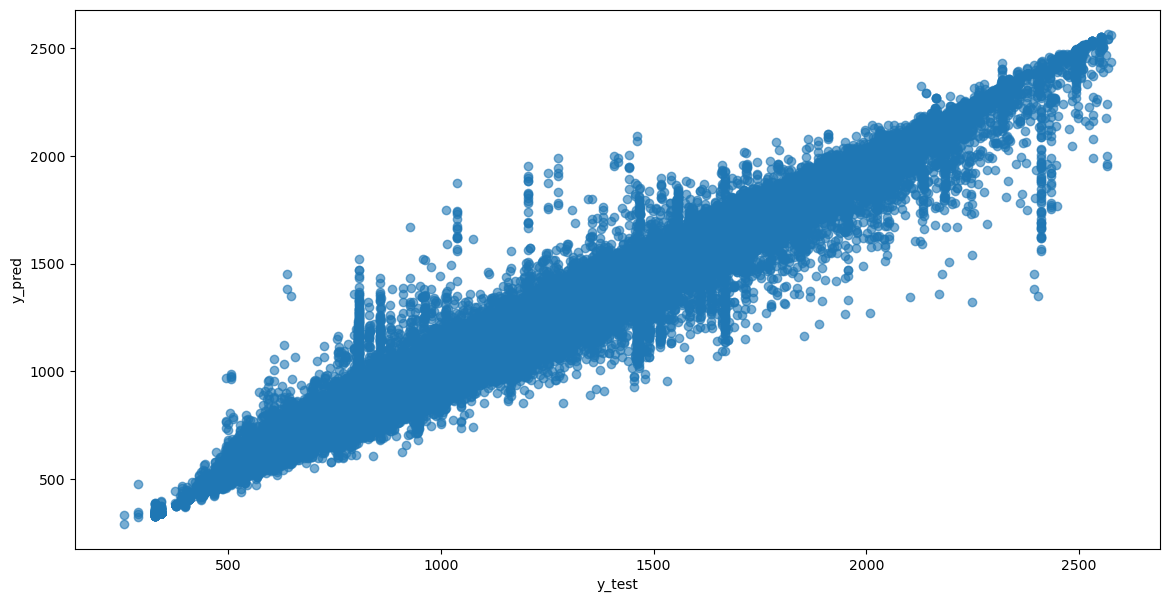

In [36]:
plt.figure(figsize=(14,7))
plt.scatter(x=y_train, y=y_pred_train, alpha =0.6)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

Outliers seems to be alot less aswell.

## Saving our work.

Here, we will use pickle library to save all the work that we have done so far. Then we will use it in a streamlit app, which will also be awailable in this repository.
We will include our label encoders to be able to use them to extract labels in the streamlit app.

In [37]:
import pickle

In [38]:
datas = {"model" : reg_rf,
         "carriers_encoded":le_car,
         "to_encoded":le_to,
         "from_encoded":le_from,
         "tod_ob_encoded":le_tod_ob,
         }

with open("model.pkl","wb") as file:
    pickle.dump(datas, file)

Finally we need our column order, in order to input our values to predict method in streamlit app.

In [39]:
X_test.columns

Index(['total_stops', 'day_of_week', 'month_number', 'day_of_month',
       'outbound_duration_minutes', 'inbound_duration_minutes', 'day_of_year',
       'to_encoded', 'from_encoded', 'carriers_encoded', 'tod_ob_encoded'],
      dtype='object')

# THE END.
### Thanks for reading this far.